In [1]:
# AeroCNN-I
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import datetime
%matplotlib inline

In [2]:
n_kernel=25
n_units=512
l2Regularizer=1e-09
kernel_size1 = 2
kernel_size2 = 5
n_grid = 101
strides = 2
input_size = 49

In [3]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [4]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [5]:
aa = aa.reshape((133, 16, 1, 1))

In [6]:
os.chdir('D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out')

In [7]:
origin = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [8]:
folders_orig = os.listdir(origin_data)
folders = [file for file in folders_orig if file.startswith('airfoil')]

In [9]:
coord_df = pd.DataFrame()
counter = 1
for i in range(1, 134):
    coord_file_name = origin_coord + "\\airfoil" + str(i) + "\\airfoilOut"+ str(i) + ".txt"
    data = pd.read_csv(coord_file_name, sep = ",", header=None)
    while counter < 17:
        coord_df = pd.concat([coord_df, data], axis=0)
        counter += 1
    counter=1

In [10]:
coord_np = coord_df.iloc[:, :].values

In [11]:
coord = coord_np.reshape((len(folders), 16, 2, 50))

In [12]:
cl_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cl_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cl_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cl_name, sep = ",", header=None)
        cl_df = pd.concat([cl_df, data], axis=0)

In [13]:
cd_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cd_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cd_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cd_name, sep = ",", header=None)
        cd_df = pd.concat([cd_df, data], axis=0)

In [14]:
cl = cl_df.iloc[:, :].values.reshape((-1,1))
cd = cd_df.iloc[:, :].values.reshape((-1,1))
y = np.hstack((cl, cd))

In [15]:
y = y.reshape((133, 16, 2, 1))

In [16]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [17]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [18]:
geometry.shape

(2128, 1)

In [19]:
geometry = geometry.reshape((133, 16, 1))

In [20]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(coord, aa, geometry, y, test_size=0.3, random_state=1)

In [21]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [22]:
input_coord = tf.keras.Input(shape=(2, 50, 1))
input_alpha = tf.keras.Input(shape=(1,1))

x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size2), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer1')(input_coord)
x_ = tf.keras.layers.MaxPooling2D((1,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size2), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer2')(x_)
x_ = tf.keras.layers.MaxPooling2D((1,2))(x_conv)
reshape1 = tf.keras.layers.Flatten()(x_)
reshape2 = tf.keras.layers.Reshape((1,))(input_alpha)
x_concat = tf.keras.layers.Concatenate(axis=1)([reshape1, reshape2])

x_ = tf.keras.layers.Dense(units=200, activation='relu', name='firstHiddenLayerSensor',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_concat)
x_ = tf.keras.layers.Dense(units=100, activation='relu', name='secondHiddenLayerSensor',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)

output_data = tf.keras.layers.Dense(units=2, activation=None, name='outputLayerSensor')(x_)
output_image = tf.keras.layers.Reshape((2, 1))(output_data)
# AeroCNN-I
model = tf.keras.Model([input_coord, input_alpha], output_image)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 50, 1)]   0           []                               
                                                                                                  
 Conv2DLayer1 (Conv2D)          (None, 1, 25, 25)    275         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 12, 25)    0           ['Conv2DLayer1[0][0]']           
                                                                                                  
 Conv2DLayer2 (Conv2D)          (None, 1, 6, 25)     6275        ['max_pooling2d[0][0]']          
                                                                                              

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [25]:
start = datetime.datetime.now()
history = model.fit([x_train,aa_train], y_train, epochs=5000, shuffle=True)
end = datetime.datetime.now()

Epoch 1/5000
47/47 [==============================] - 14s 13ms/step - loss: 0.1549 - rmse: 0.3935
Epoch 2/5000
47/47 [==============================] - 1s 12ms/step - loss: 0.0228 - rmse: 0.1511
Epoch 3/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0171 - rmse: 0.1307
Epoch 4/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0139 - rmse: 0.1180
Epoch 5/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0138 - rmse: 0.1175
Epoch 6/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0135 - rmse: 0.1161
Epoch 7/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0122 - rmse: 0.1104
Epoch 8/5000
47/47 [==============================] - 1s 11ms/step - loss: 0.0110 - rmse: 0.1047
Epoch 9/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0107 - rmse: 0.1032
Epoch 10/5000
47/47 [==============================] - 1s 12ms/step - loss: 0.0105 - rmse: 0.1025
Epoch 11/5000
47/47 [========

47/47 [==============================] - 0s 8ms/step - loss: 0.0061 - rmse: 0.0783
Epoch 86/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0059 - rmse: 0.0765
Epoch 87/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0058 - rmse: 0.0765
Epoch 88/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0062 - rmse: 0.0785
Epoch 89/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0069 - rmse: 0.0830
Epoch 90/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0063 - rmse: 0.0794
Epoch 91/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0060 - rmse: 0.0772
Epoch 92/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0061 - rmse: 0.0783
Epoch 93/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0058 - rmse: 0.0765
Epoch 94/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0055 - rmse: 0.0743
Epoch 95/5000
47/47 [=======================

47/47 [==============================] - 0s 10ms/step - loss: 0.0050 - rmse: 0.0706
Epoch 169/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0052 - rmse: 0.0721
Epoch 170/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0050 - rmse: 0.0704
Epoch 171/5000
47/47 [==============================] - 1s 11ms/step - loss: 0.0051 - rmse: 0.0712
Epoch 172/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0049 - rmse: 0.0696
Epoch 173/5000
47/47 [==============================] - 1s 11ms/step - loss: 0.0052 - rmse: 0.0718
Epoch 174/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0050 - rmse: 0.0709
Epoch 175/5000
47/47 [==============================] - 1s 11ms/step - loss: 0.0047 - rmse: 0.0686
Epoch 176/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0053 - rmse: 0.0726
Epoch 177/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0051 - rmse: 0.0715
Epoch 178/5000
47/47 [=======

47/47 [==============================] - 0s 8ms/step - loss: 0.0042 - rmse: 0.0649
Epoch 252/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0045 - rmse: 0.0669
Epoch 253/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0042 - rmse: 0.0651
Epoch 254/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0041 - rmse: 0.0638
Epoch 255/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0045 - rmse: 0.0673
Epoch 256/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0045 - rmse: 0.0670
Epoch 257/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0042 - rmse: 0.0646
Epoch 258/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0048 - rmse: 0.0693
Epoch 259/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0040 - rmse: 0.0635
Epoch 260/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0039 - rmse: 0.0626
Epoch 261/5000
47/47 [============

47/47 [==============================] - 0s 9ms/step - loss: 0.0038 - rmse: 0.0619
Epoch 335/5000
47/47 [==============================] - 1s 12ms/step - loss: 0.0037 - rmse: 0.0605
Epoch 336/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0033 - rmse: 0.0570
Epoch 337/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0034 - rmse: 0.0582
Epoch 338/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0039 - rmse: 0.0622
Epoch 339/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0040 - rmse: 0.0630
Epoch 340/5000
47/47 [==============================] - 1s 11ms/step - loss: 0.0035 - rmse: 0.0593
Epoch 341/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0036 - rmse: 0.0602
Epoch 342/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0035 - rmse: 0.0592
Epoch 343/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0035 - rmse: 0.0593
Epoch 344/5000
47/47 [======

47/47 [==============================] - 0s 8ms/step - loss: 0.0031 - rmse: 0.0559
Epoch 418/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0031 - rmse: 0.0561
Epoch 419/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0031 - rmse: 0.0556
Epoch 420/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0030 - rmse: 0.0551
Epoch 421/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0031 - rmse: 0.0554
Epoch 422/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0028 - rmse: 0.0530
Epoch 423/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0030 - rmse: 0.0552
Epoch 424/5000
47/47 [==============================] - 1s 11ms/step - loss: 0.0031 - rmse: 0.0558
Epoch 425/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0029 - rmse: 0.0534
Epoch 426/5000
47/47 [==============================] - 1s 11ms/step - loss: 0.0032 - rmse: 0.0563
Epoch 427/5000
47/47 [=========

47/47 [==============================] - 1s 11ms/step - loss: 0.0026 - rmse: 0.0512
Epoch 501/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0029 - rmse: 0.0536
Epoch 502/5000
47/47 [==============================] - 1s 11ms/step - loss: 0.0027 - rmse: 0.0517
Epoch 503/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0025 - rmse: 0.0501
Epoch 504/5000
47/47 [==============================] - 1s 11ms/step - loss: 0.0030 - rmse: 0.0544
Epoch 505/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0026 - rmse: 0.0508
Epoch 506/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0024 - rmse: 0.0494
Epoch 507/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0028 - rmse: 0.0525
Epoch 508/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0029 - rmse: 0.0541
Epoch 509/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0027 - rmse: 0.0524
Epoch 510/5000
47/47 [=========

47/47 [==============================] - 0s 9ms/step - loss: 0.0022 - rmse: 0.0467
Epoch 584/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0021 - rmse: 0.0458
Epoch 585/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0023 - rmse: 0.0481
Epoch 586/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0022 - rmse: 0.0474
Epoch 587/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0021 - rmse: 0.0457
Epoch 588/5000
47/47 [==============================] - 0s 11ms/step - loss: 0.0023 - rmse: 0.0476
Epoch 589/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0027 - rmse: 0.0522
Epoch 590/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0026 - rmse: 0.0510
Epoch 591/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0023 - rmse: 0.0480
Epoch 592/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0024 - rmse: 0.0490
Epoch 593/5000
47/47 [===========

47/47 [==============================] - 0s 9ms/step - loss: 0.0020 - rmse: 0.0444
Epoch 667/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0020 - rmse: 0.0444
Epoch 668/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0017 - rmse: 0.0417
Epoch 669/5000
47/47 [==============================] - 1s 11ms/step - loss: 0.0019 - rmse: 0.0441
Epoch 670/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0019 - rmse: 0.0430
Epoch 671/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0020 - rmse: 0.0445
Epoch 672/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0025 - rmse: 0.0500
Epoch 673/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0022 - rmse: 0.0469
Epoch 674/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0018 - rmse: 0.0421
Epoch 675/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0019 - rmse: 0.0441
Epoch 676/5000
47/47 [=========

47/47 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0410
Epoch 750/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0411
Epoch 751/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0027 - rmse: 0.0516
Epoch 752/5000
47/47 [==============================] - 1s 11ms/step - loss: 0.0018 - rmse: 0.0423
Epoch 753/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0017 - rmse: 0.0409
Epoch 754/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0015 - rmse: 0.0390
Epoch 755/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0014 - rmse: 0.0379
Epoch 756/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0017 - rmse: 0.0416
Epoch 757/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0016 - rmse: 0.0401
Epoch 758/5000
47/47 [==============================] - 1s 11ms/step - loss: 0.0018 - rmse: 0.0422
Epoch 759/5000
47/47 [======

47/47 [==============================] - 1s 11ms/step - loss: 0.0017 - rmse: 0.0409
Epoch 833/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0019 - rmse: 0.0436
Epoch 834/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 0.0393
Epoch 835/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0353
Epoch 836/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0344
Epoch 837/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0015 - rmse: 0.0385
Epoch 838/5000
47/47 [==============================] - 0s 11ms/step - loss: 0.0016 - rmse: 0.0399
Epoch 839/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0016 - rmse: 0.0404
Epoch 840/5000
47/47 [==============================] - 1s 11ms/step - loss: 0.0016 - rmse: 0.0401
Epoch 841/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0012 - rmse: 0.0343
Epoch 842/5000
47/47 [=======

47/47 [==============================] - 0s 10ms/step - loss: 0.0018 - rmse: 0.0420
Epoch 916/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0018 - rmse: 0.0422
Epoch 917/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0014 - rmse: 0.0375
Epoch 918/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0010 - rmse: 0.0322
Epoch 919/5000
47/47 [==============================] - 1s 11ms/step - loss: 0.0011 - rmse: 0.0329
Epoch 920/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0011 - rmse: 0.0326
Epoch 921/5000
47/47 [==============================] - 1s 11ms/step - loss: 0.0011 - rmse: 0.0338
Epoch 922/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0014 - rmse: 0.0370
Epoch 923/5000
47/47 [==============================] - 1s 12ms/step - loss: 0.0016 - rmse: 0.0400
Epoch 924/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0014 - rmse: 0.0379
Epoch 925/5000
47/47 [====

47/47 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0357
Epoch 998/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0327
Epoch 999/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0012 - rmse: 0.0351
Epoch 1000/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0011 - rmse: 0.0328
Epoch 1001/5000
47/47 [==============================] - 1s 11ms/step - loss: 0.0012 - rmse: 0.0350
Epoch 1002/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0013 - rmse: 0.0354
Epoch 1003/5000
47/47 [==============================] - 0s 9ms/step - loss: 9.4361e-04 - rmse: 0.0307
Epoch 1004/5000
47/47 [==============================] - 1s 11ms/step - loss: 0.0011 - rmse: 0.0336
Epoch 1005/5000
47/47 [==============================] - 1s 12ms/step - loss: 0.0014 - rmse: 0.0368
Epoch 1006/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0416
Epoch 1007/5000
47/4

47/47 [==============================] - 0s 10ms/step - loss: 0.0012 - rmse: 0.0353
Epoch 1079/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0010 - rmse: 0.0321
Epoch 1080/5000
47/47 [==============================] - 0s 10ms/step - loss: 9.1852e-04 - rmse: 0.0303
Epoch 1081/5000
47/47 [==============================] - 0s 10ms/step - loss: 7.5218e-04 - rmse: 0.0274
Epoch 1082/5000
47/47 [==============================] - 1s 12ms/step - loss: 9.7484e-04 - rmse: 0.0312
Epoch 1083/5000
47/47 [==============================] - 0s 10ms/step - loss: 8.6987e-04 - rmse: 0.0295
Epoch 1084/5000
47/47 [==============================] - 0s 10ms/step - loss: 8.5714e-04 - rmse: 0.0293
Epoch 1085/5000
47/47 [==============================] - 1s 11ms/step - loss: 7.2530e-04 - rmse: 0.0269
Epoch 1086/5000
47/47 [==============================] - 0s 9ms/step - loss: 6.6861e-04 - rmse: 0.0258
Epoch 1087/5000
47/47 [==============================] - 1s 12ms/step - loss: 7.9869e-04 

47/47 [==============================] - 1s 11ms/step - loss: 6.6558e-04 - rmse: 0.0258
Epoch 1159/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.0236e-04 - rmse: 0.0265
Epoch 1160/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.8613e-04 - rmse: 0.0262
Epoch 1161/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.3102e-04 - rmse: 0.0251
Epoch 1162/5000
47/47 [==============================] - 0s 9ms/step - loss: 6.5908e-04 - rmse: 0.0256
Epoch 1163/5000
47/47 [==============================] - 0s 10ms/step - loss: 6.6136e-04 - rmse: 0.0257
Epoch 1164/5000
47/47 [==============================] - 0s 10ms/step - loss: 7.4861e-04 - rmse: 0.0273
Epoch 1165/5000
47/47 [==============================] - 0s 11ms/step - loss: 6.9097e-04 - rmse: 0.0263
Epoch 1166/5000
47/47 [==============================] - 0s 10ms/step - loss: 9.7775e-04 - rmse: 0.0312
Epoch 1167/5000
47/47 [==============================] - 1s 13ms/step - loss: 0.0016

47/47 [==============================] - 0s 10ms/step - loss: 0.0031 - rmse: 0.0555
Epoch 1239/5000
47/47 [==============================] - 0s 11ms/step - loss: 0.0033 - rmse: 0.0570
Epoch 1240/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0021 - rmse: 0.0463
Epoch 1241/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0022 - rmse: 0.0465
Epoch 1242/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0018 - rmse: 0.0420
Epoch 1243/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0012 - rmse: 0.0341
Epoch 1244/5000
47/47 [==============================] - 1s 12ms/step - loss: 0.0023 - rmse: 0.0482
Epoch 1245/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0019 - rmse: 0.0435
Epoch 1246/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0012 - rmse: 0.0339
Epoch 1247/5000
47/47 [==============================] - 1s 11ms/step - loss: 7.8784e-04 - rmse: 0.0280
Epoch 1248/5

47/47 [==============================] - 0s 9ms/step - loss: 5.9175e-04 - rmse: 0.0243
Epoch 1319/5000
47/47 [==============================] - 1s 11ms/step - loss: 5.1385e-04 - rmse: 0.0226
Epoch 1320/5000
47/47 [==============================] - 0s 10ms/step - loss: 5.2481e-04 - rmse: 0.0229
Epoch 1321/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.0019e-04 - rmse: 0.0223
Epoch 1322/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.4213e-04 - rmse: 0.0233
Epoch 1323/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.0310e-04 - rmse: 0.0265
Epoch 1324/5000
47/47 [==============================] - 0s 10ms/step - loss: 5.4618e-04 - rmse: 0.0233
Epoch 1325/5000
47/47 [==============================] - 1s 11ms/step - loss: 7.5262e-04 - rmse: 0.0274
Epoch 1326/5000
47/47 [==============================] - 0s 10ms/step - loss: 6.6767e-04 - rmse: 0.0258
Epoch 1327/5000
47/47 [==============================] - 0s 10ms/step - loss: 6.7283

47/47 [==============================] - 0s 9ms/step - loss: 4.5283e-04 - rmse: 0.0212
Epoch 1398/5000
47/47 [==============================] - 0s 9ms/step - loss: 4.7779e-04 - rmse: 0.0218
Epoch 1399/5000
47/47 [==============================] - 1s 11ms/step - loss: 4.5836e-04 - rmse: 0.0214
Epoch 1400/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.7975e-04 - rmse: 0.0219
Epoch 1401/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.5213e-04 - rmse: 0.0212
Epoch 1402/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.8380e-04 - rmse: 0.0220
Epoch 1403/5000
47/47 [==============================] - 0s 10ms/step - loss: 5.7435e-04 - rmse: 0.0239
Epoch 1404/5000
47/47 [==============================] - 0s 10ms/step - loss: 6.5390e-04 - rmse: 0.0255
Epoch 1405/5000
47/47 [==============================] - 1s 11ms/step - loss: 5.4560e-04 - rmse: 0.0233
Epoch 1406/5000
47/47 [==============================] - 0s 9ms/step - loss: 5.654

47/47 [==============================] - 0s 9ms/step - loss: 0.0014 - rmse: 0.0380
Epoch 1477/5000
47/47 [==============================] - 0s 10ms/step - loss: 8.0881e-04 - rmse: 0.0284
Epoch 1478/5000
47/47 [==============================] - 1s 11ms/step - loss: 6.2593e-04 - rmse: 0.0250
Epoch 1479/5000
47/47 [==============================] - 1s 11ms/step - loss: 4.9176e-04 - rmse: 0.0221
Epoch 1480/5000
47/47 [==============================] - 0s 10ms/step - loss: 5.1964e-04 - rmse: 0.0228
Epoch 1481/5000
47/47 [==============================] - 1s 12ms/step - loss: 5.2502e-04 - rmse: 0.0229
Epoch 1482/5000
47/47 [==============================] - 0s 9ms/step - loss: 5.2218e-04 - rmse: 0.0228
Epoch 1483/5000
47/47 [==============================] - 0s 8ms/step - loss: 4.2715e-04 - rmse: 0.0206
Epoch 1484/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.4015e-04 - rmse: 0.0232
Epoch 1485/5000
47/47 [==============================] - 0s 9ms/step - loss: 5.8336e-04 

47/47 [==============================] - 0s 8ms/step - loss: 6.3541e-04 - rmse: 0.0252
Epoch 1556/5000
47/47 [==============================] - 0s 9ms/step - loss: 4.8930e-04 - rmse: 0.0221
Epoch 1557/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.2578e-04 - rmse: 0.0229
Epoch 1558/5000
47/47 [==============================] - 0s 8ms/step - loss: 4.3984e-04 - rmse: 0.0209
Epoch 1559/5000
47/47 [==============================] - 0s 9ms/step - loss: 5.1706e-04 - rmse: 0.0227
Epoch 1560/5000
47/47 [==============================] - 1s 11ms/step - loss: 4.7133e-04 - rmse: 0.0217
Epoch 1561/5000
47/47 [==============================] - 0s 10ms/step - loss: 5.2223e-04 - rmse: 0.0228
Epoch 1562/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.5755e-04 - rmse: 0.0214
Epoch 1563/5000
47/47 [==============================] - 0s 10ms/step - loss: 5.0085e-04 - rmse: 0.0223
Epoch 1564/5000
47/47 [==============================] - 0s 9ms/step - loss: 5.6338e-

47/47 [==============================] - 0s 10ms/step - loss: 4.7901e-04 - rmse: 0.0219
Epoch 1635/5000
47/47 [==============================] - 1s 11ms/step - loss: 3.8698e-04 - rmse: 0.0196
Epoch 1636/5000
47/47 [==============================] - 0s 9ms/step - loss: 3.9325e-04 - rmse: 0.0198
Epoch 1637/5000
47/47 [==============================] - 1s 12ms/step - loss: 4.4883e-04 - rmse: 0.0211
Epoch 1638/5000
47/47 [==============================] - 0s 9ms/step - loss: 5.0137e-04 - rmse: 0.0224
Epoch 1639/5000
47/47 [==============================] - 0s 9ms/step - loss: 4.5964e-04 - rmse: 0.0214
Epoch 1640/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.9127e-04 - rmse: 0.0197
Epoch 1641/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.8627e-04 - rmse: 0.0196
Epoch 1642/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.2298e-04 - rmse: 0.0205
Epoch 1643/5000
47/47 [==============================] - 1s 12ms/step - loss: 4.208

47/47 [==============================] - 0s 9ms/step - loss: 4.4438e-04 - rmse: 0.0210
Epoch 1714/5000
47/47 [==============================] - 0s 9ms/step - loss: 4.3588e-04 - rmse: 0.0208
Epoch 1715/5000
47/47 [==============================] - 0s 9ms/step - loss: 4.1866e-04 - rmse: 0.0204
Epoch 1716/5000
47/47 [==============================] - 0s 8ms/step - loss: 4.9390e-04 - rmse: 0.0222
Epoch 1717/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.0159e-04 - rmse: 0.0224
Epoch 1718/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.7620e-04 - rmse: 0.0218
Epoch 1719/5000
47/47 [==============================] - 0s 9ms/step - loss: 5.5106e-04 - rmse: 0.0234
Epoch 1720/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.1425e-04 - rmse: 0.0248
Epoch 1721/5000
47/47 [==============================] - 0s 9ms/step - loss: 4.5412e-04 - rmse: 0.0213
Epoch 1722/5000
47/47 [==============================] - 1s 11ms/step - loss: 4.9507e-04

47/47 [==============================] - 0s 10ms/step - loss: 3.4476e-04 - rmse: 0.0185
Epoch 1793/5000
47/47 [==============================] - 0s 11ms/step - loss: 3.7685e-04 - rmse: 0.0194
Epoch 1794/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.2593e-04 - rmse: 0.0206
Epoch 1795/5000
47/47 [==============================] - 1s 12ms/step - loss: 4.9702e-04 - rmse: 0.0223
Epoch 1796/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.0184e-04 - rmse: 0.0200
Epoch 1797/5000
47/47 [==============================] - 1s 12ms/step - loss: 6.8144e-04 - rmse: 0.0261
Epoch 1798/5000
47/47 [==============================] - 0s 9ms/step - loss: 6.5130e-04 - rmse: 0.0255
Epoch 1799/5000
47/47 [==============================] - 1s 11ms/step - loss: 4.1600e-04 - rmse: 0.0204
Epoch 1800/5000
47/47 [==============================] - 0s 10ms/step - loss: 5.4062e-04 - rmse: 0.0232
Epoch 1801/5000
47/47 [==============================] - 0s 9ms/step - loss: 5.61

47/47 [==============================] - 0s 8ms/step - loss: 4.9794e-04 - rmse: 0.0223
Epoch 1872/5000
47/47 [==============================] - 0s 9ms/step - loss: 6.5580e-04 - rmse: 0.0256
Epoch 1873/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0033 - rmse: 0.0575
Epoch 1874/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0035 - rmse: 0.0594
Epoch 1875/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0415
Epoch 1876/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0012 - rmse: 0.0347
Epoch 1877/5000
47/47 [==============================] - 0s 9ms/step - loss: 9.2232e-04 - rmse: 0.0303
Epoch 1878/5000
47/47 [==============================] - 0s 9ms/step - loss: 5.4601e-04 - rmse: 0.0233
Epoch 1879/5000
47/47 [==============================] - 0s 9ms/step - loss: 5.5047e-04 - rmse: 0.0234
Epoch 1880/5000
47/47 [==============================] - 0s 8ms/step - loss: 4.6950e-04 - rmse: 0.0216
Ep

47/47 [==============================] - 0s 10ms/step - loss: 4.1801e-04 - rmse: 0.0204
Epoch 1951/5000
47/47 [==============================] - 1s 11ms/step - loss: 4.3610e-04 - rmse: 0.0208
Epoch 1952/5000
47/47 [==============================] - 0s 9ms/step - loss: 4.1394e-04 - rmse: 0.0203
Epoch 1953/5000
47/47 [==============================] - 0s 11ms/step - loss: 3.9472e-04 - rmse: 0.0198
Epoch 1954/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.1798e-04 - rmse: 0.0204
Epoch 1955/5000
47/47 [==============================] - 0s 11ms/step - loss: 5.1241e-04 - rmse: 0.0226
Epoch 1956/5000
47/47 [==============================] - 0s 10ms/step - loss: 0.0014 - rmse: 0.0368
Epoch 1957/5000
47/47 [==============================] - 1s 11ms/step - loss: 5.9923e-04 - rmse: 0.0244
Epoch 1958/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.9606e-04 - rmse: 0.0222
Epoch 1959/5000
47/47 [==============================] - 1s 11ms/step - loss: 4.0288e

47/47 [==============================] - 1s 11ms/step - loss: 3.8064e-04 - rmse: 0.0195
Epoch 2030/5000
47/47 [==============================] - 1s 12ms/step - loss: 3.4567e-04 - rmse: 0.0185
Epoch 2031/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.4858e-04 - rmse: 0.0186
Epoch 2032/5000
47/47 [==============================] - 1s 13ms/step - loss: 3.3216e-04 - rmse: 0.0182
Epoch 2033/5000
47/47 [==============================] - 0s 9ms/step - loss: 3.0912e-04 - rmse: 0.0175
Epoch 2034/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.1234e-04 - rmse: 0.0176
Epoch 2035/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.8136e-04 - rmse: 0.0195
Epoch 2036/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.5504e-04 - rmse: 0.0188
Epoch 2037/5000
47/47 [==============================] - 0s 9ms/step - loss: 3.4939e-04 - rmse: 0.0186
Epoch 2038/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.3122e-

47/47 [==============================] - 0s 10ms/step - loss: 4.4294e-04 - rmse: 0.0210
Epoch 2109/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.4850e-04 - rmse: 0.0211
Epoch 2110/5000
47/47 [==============================] - 1s 11ms/step - loss: 3.9555e-04 - rmse: 0.0198
Epoch 2111/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.8140e-04 - rmse: 0.0219
Epoch 2112/5000
47/47 [==============================] - 1s 11ms/step - loss: 3.8303e-04 - rmse: 0.0195
Epoch 2113/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.8131e-04 - rmse: 0.0195
Epoch 2114/5000
47/47 [==============================] - 1s 11ms/step - loss: 4.7834e-04 - rmse: 0.0218
Epoch 2115/5000
47/47 [==============================] - 1s 11ms/step - loss: 5.7499e-04 - rmse: 0.0239
Epoch 2116/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.1839e-04 - rmse: 0.0204
Epoch 2117/5000
47/47 [==============================] - 0s 11ms/step - loss: 3.

47/47 [==============================] - 0s 8ms/step - loss: 3.1184e-04 - rmse: 0.0176
Epoch 2188/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.0887e-04 - rmse: 0.0175
Epoch 2189/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.8115e-04 - rmse: 0.0167
Epoch 2190/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.2604e-04 - rmse: 0.0206
Epoch 2191/5000
47/47 [==============================] - 1s 11ms/step - loss: 3.6489e-04 - rmse: 0.0191
Epoch 2192/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.6995e-04 - rmse: 0.0164
Epoch 2193/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.9777e-04 - rmse: 0.0172
Epoch 2194/5000
47/47 [==============================] - 1s 12ms/step - loss: 2.6923e-04 - rmse: 0.0164
Epoch 2195/5000
47/47 [==============================] - 1s 12ms/step - loss: 3.1012e-04 - rmse: 0.0176
Epoch 2196/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.0371e

47/47 [==============================] - 0s 9ms/step - loss: 4.0506e-04 - rmse: 0.0201
Epoch 2267/5000
47/47 [==============================] - 1s 11ms/step - loss: 4.3010e-04 - rmse: 0.0207
Epoch 2268/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.5775e-04 - rmse: 0.0189
Epoch 2269/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.8410e-04 - rmse: 0.0168
Epoch 2270/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.7477e-04 - rmse: 0.0193
Epoch 2271/5000
47/47 [==============================] - 0s 10ms/step - loss: 5.3195e-04 - rmse: 0.0230
Epoch 2272/5000
47/47 [==============================] - 0s 10ms/step - loss: 6.2480e-04 - rmse: 0.0250
Epoch 2273/5000
47/47 [==============================] - 0s 10ms/step - loss: 5.2724e-04 - rmse: 0.0229
Epoch 2274/5000
47/47 [==============================] - 1s 11ms/step - loss: 3.8788e-04 - rmse: 0.0196
Epoch 2275/5000
47/47 [==============================] - 1s 11ms/step - loss: 3.3

47/47 [==============================] - 0s 10ms/step - loss: 2.9462e-04 - rmse: 0.0171
Epoch 2346/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.9921e-04 - rmse: 0.0172
Epoch 2347/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.4569e-04 - rmse: 0.0185
Epoch 2348/5000
47/47 [==============================] - 1s 11ms/step - loss: 2.3831e-04 - rmse: 0.0154
Epoch 2349/5000
47/47 [==============================] - 0s 8ms/step - loss: 4.6938e-04 - rmse: 0.0216
Epoch 2350/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.1094e-04 - rmse: 0.0226
Epoch 2351/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.9243e-04 - rmse: 0.0198
Epoch 2352/5000
47/47 [==============================] - 0s 9ms/step - loss: 4.1809e-04 - rmse: 0.0204
Epoch 2353/5000
47/47 [==============================] - 1s 11ms/step - loss: 3.7177e-04 - rmse: 0.0192
Epoch 2354/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.8061

47/47 [==============================] - 0s 9ms/step - loss: 5.8918e-04 - rmse: 0.0242
Epoch 2425/5000
47/47 [==============================] - 0s 8ms/step - loss: 4.6755e-04 - rmse: 0.0216
Epoch 2426/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.9736e-04 - rmse: 0.0199
Epoch 2427/5000
47/47 [==============================] - 0s 9ms/step - loss: 3.4217e-04 - rmse: 0.0184
Epoch 2428/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.7303e-04 - rmse: 0.0165
Epoch 2429/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.9123e-04 - rmse: 0.0170
Epoch 2430/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.8358e-04 - rmse: 0.0195
Epoch 2431/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.9054e-04 - rmse: 0.0197
Epoch 2432/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.1912e-04 - rmse: 0.0178
Epoch 2433/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.4085

47/47 [==============================] - 0s 10ms/step - loss: 4.4320e-04 - rmse: 0.0210
Epoch 2504/5000
47/47 [==============================] - 0s 11ms/step - loss: 3.4951e-04 - rmse: 0.0186
Epoch 2505/5000
47/47 [==============================] - 0s 9ms/step - loss: 4.5195e-04 - rmse: 0.0212
Epoch 2506/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.4929e-04 - rmse: 0.0211
Epoch 2507/5000
47/47 [==============================] - 0s 9ms/step - loss: 5.1124e-04 - rmse: 0.0226
Epoch 2508/5000
47/47 [==============================] - 1s 11ms/step - loss: 4.0529e-04 - rmse: 0.0201
Epoch 2509/5000
47/47 [==============================] - 0s 9ms/step - loss: 3.1273e-04 - rmse: 0.0176
Epoch 2510/5000
47/47 [==============================] - 1s 11ms/step - loss: 4.5703e-04 - rmse: 0.0213
Epoch 2511/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.8046e-04 - rmse: 0.0195
Epoch 2512/5000
47/47 [==============================] - 0s 8ms/step - loss: 4.7867

47/47 [==============================] - 0s 9ms/step - loss: 8.5730e-04 - rmse: 0.0292
Epoch 2583/5000
47/47 [==============================] - 0s 9ms/step - loss: 4.9282e-04 - rmse: 0.0222
Epoch 2584/5000
47/47 [==============================] - 0s 9ms/step - loss: 3.6274e-04 - rmse: 0.0190
Epoch 2585/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.9309e-04 - rmse: 0.0171
Epoch 2586/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.4048e-04 - rmse: 0.0154
Epoch 2587/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.5958e-04 - rmse: 0.0160
Epoch 2588/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.3400e-04 - rmse: 0.0152
Epoch 2589/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.3308e-04 - rmse: 0.0152
Epoch 2590/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.0786e-04 - rmse: 0.0143
Epoch 2591/5000
47/47 [==============================] - 1s 11ms/step - loss: 2.2234e-04

47/47 [==============================] - 0s 10ms/step - loss: 5.6931e-04 - rmse: 0.0238
Epoch 2662/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.4367e-04 - rmse: 0.0210
Epoch 2663/5000
47/47 [==============================] - 0s 11ms/step - loss: 4.2175e-04 - rmse: 0.0205
Epoch 2664/5000
47/47 [==============================] - 1s 11ms/step - loss: 3.1190e-04 - rmse: 0.0176
Epoch 2665/5000
47/47 [==============================] - 1s 11ms/step - loss: 3.0378e-04 - rmse: 0.0174
Epoch 2666/5000
47/47 [==============================] - 1s 11ms/step - loss: 2.5446e-04 - rmse: 0.0159
Epoch 2667/5000
47/47 [==============================] - 0s 9ms/step - loss: 3.0067e-04 - rmse: 0.0173
Epoch 2668/5000
47/47 [==============================] - 1s 12ms/step - loss: 3.1047e-04 - rmse: 0.0176
Epoch 2669/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.4768e-04 - rmse: 0.0157
Epoch 2670/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.72

47/47 [==============================] - 0s 8ms/step - loss: 2.3503e-04 - rmse: 0.0153
Epoch 2741/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.1473e-04 - rmse: 0.0146
Epoch 2742/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.2063e-04 - rmse: 0.0148
Epoch 2743/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.4774e-04 - rmse: 0.0157
Epoch 2744/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.2506e-04 - rmse: 0.0149
Epoch 2745/5000
47/47 [==============================] - 0s 9ms/step - loss: 3.2089e-04 - rmse: 0.0179
Epoch 2746/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.7081e-04 - rmse: 0.0164
Epoch 2747/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.9506e-04 - rmse: 0.0171
Epoch 2748/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.3208e-04 - rmse: 0.0182
Epoch 2749/5000
47/47 [==============================] - 0s 9ms/step - loss: 3.3585e-04 -

47/47 [==============================] - 0s 9ms/step - loss: 3.7223e-04 - rmse: 0.0192
Epoch 2820/5000
47/47 [==============================] - 1s 12ms/step - loss: 3.8942e-04 - rmse: 0.0197
Epoch 2821/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.6728e-04 - rmse: 0.0191
Epoch 2822/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.6408e-04 - rmse: 0.0190
Epoch 2823/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.4380e-04 - rmse: 0.0185
Epoch 2824/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.9766e-04 - rmse: 0.0172
Epoch 2825/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.2659e-04 - rmse: 0.0150
Epoch 2826/5000
47/47 [==============================] - 1s 11ms/step - loss: 2.7732e-04 - rmse: 0.0166
Epoch 2827/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.5092e-04 - rmse: 0.0158
Epoch 2828/5000
47/47 [==============================] - 1s 11ms/step - loss: 2.50

47/47 [==============================] - 0s 10ms/step - loss: 3.1907e-04 - rmse: 0.0178
Epoch 2899/5000
47/47 [==============================] - 1s 13ms/step - loss: 2.4262e-04 - rmse: 0.0155
Epoch 2900/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.2267e-04 - rmse: 0.0148
Epoch 2901/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.1582e-04 - rmse: 0.0177
Epoch 2902/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.8105e-04 - rmse: 0.0167
Epoch 2903/5000
47/47 [==============================] - 0s 9ms/step - loss: 3.1580e-04 - rmse: 0.0177
Epoch 2904/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.5621e-04 - rmse: 0.0159
Epoch 2905/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.2171e-04 - rmse: 0.0148
Epoch 2906/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.7031e-04 - rmse: 0.0164
Epoch 2907/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.5112e-04

47/47 [==============================] - 1s 12ms/step - loss: 3.1675e-04 - rmse: 0.0177
Epoch 2978/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.6273e-04 - rmse: 0.0161
Epoch 2979/5000
47/47 [==============================] - 1s 11ms/step - loss: 1.9520e-04 - rmse: 0.0139
Epoch 2980/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.2780e-04 - rmse: 0.0150
Epoch 2981/5000
47/47 [==============================] - 1s 11ms/step - loss: 1.9701e-04 - rmse: 0.0140
Epoch 2982/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.7999e-04 - rmse: 0.0133
Epoch 2983/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.2845e-04 - rmse: 0.0150
Epoch 2984/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.9185e-04 - rmse: 0.0170
Epoch 2985/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.5202e-04 - rmse: 0.0158
Epoch 2986/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.13

47/47 [==============================] - 0s 10ms/step - loss: 2.6806e-04 - rmse: 0.0163
Epoch 3057/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.7733e-04 - rmse: 0.0194
Epoch 3058/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.5044e-04 - rmse: 0.0187
Epoch 3059/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.1625e-04 - rmse: 0.0267
Epoch 3060/5000
47/47 [==============================] - 0s 10ms/step - loss: 5.7571e-04 - rmse: 0.0239
Epoch 3061/5000
47/47 [==============================] - 1s 12ms/step - loss: 3.2225e-04 - rmse: 0.0179
Epoch 3062/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.1132e-04 - rmse: 0.0202
Epoch 3063/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.2812e-04 - rmse: 0.0181
Epoch 3064/5000
47/47 [==============================] - 0s 11ms/step - loss: 3.1022e-04 - rmse: 0.0175
Epoch 3065/5000
47/47 [==============================] - 1s 13ms/step - loss: 2.974

47/47 [==============================] - 0s 8ms/step - loss: 3.2414e-04 - rmse: 0.0179
Epoch 3136/5000
47/47 [==============================] - 0s 9ms/step - loss: 4.8506e-04 - rmse: 0.0220
Epoch 3137/5000
47/47 [==============================] - 1s 11ms/step - loss: 3.6763e-04 - rmse: 0.0191
Epoch 3138/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.0670e-04 - rmse: 0.0174
Epoch 3139/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.8228e-04 - rmse: 0.0167
Epoch 3140/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.0010e-04 - rmse: 0.0141
Epoch 3141/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.4541e-04 - rmse: 0.0156
Epoch 3142/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.6353e-04 - rmse: 0.0162
Epoch 3143/5000
47/47 [==============================] - 1s 11ms/step - loss: 2.2651e-04 - rmse: 0.0150
Epoch 3144/5000
47/47 [==============================] - 1s 11ms/step - loss: 4.23

47/47 [==============================] - 0s 11ms/step - loss: 5.6968e-04 - rmse: 0.0238
Epoch 3215/5000
47/47 [==============================] - 0s 9ms/step - loss: 3.6021e-04 - rmse: 0.0189
Epoch 3216/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.7240e-04 - rmse: 0.0192
Epoch 3217/5000
47/47 [==============================] - 0s 9ms/step - loss: 3.9281e-04 - rmse: 0.0198
Epoch 3218/5000
47/47 [==============================] - 0s 10ms/step - loss: 9.7821e-04 - rmse: 0.0312
Epoch 3219/5000
47/47 [==============================] - 0s 10ms/step - loss: 6.9178e-04 - rmse: 0.0263
Epoch 3220/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.7686e-04 - rmse: 0.0166
Epoch 3221/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.1646e-04 - rmse: 0.0146
Epoch 3222/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.0377e-04 - rmse: 0.0142
Epoch 3223/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.8541e-

47/47 [==============================] - 0s 8ms/step - loss: 3.0595e-04 - rmse: 0.0174
Epoch 3294/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.1616e-04 - rmse: 0.0146
Epoch 3295/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.9339e-04 - rmse: 0.0138
Epoch 3296/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.8578e-04 - rmse: 0.0135
Epoch 3297/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.3371e-04 - rmse: 0.0152
Epoch 3298/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.8074e-04 - rmse: 0.0134
Epoch 3299/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.5327e-04 - rmse: 0.0158
Epoch 3300/5000
47/47 [==============================] - 1s 11ms/step - loss: 2.5353e-04 - rmse: 0.0158
Epoch 3301/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.2406e-04 - rmse: 0.0149
Epoch 3302/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.6609e-0

47/47 [==============================] - 1s 11ms/step - loss: 1.7354e-04 - rmse: 0.0131
Epoch 3373/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.8986e-04 - rmse: 0.0137
Epoch 3374/5000
47/47 [==============================] - 1s 11ms/step - loss: 2.0237e-04 - rmse: 0.0141
Epoch 3375/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.8873e-04 - rmse: 0.0136
Epoch 3376/5000
47/47 [==============================] - 1s 11ms/step - loss: 1.8254e-04 - rmse: 0.0134
Epoch 3377/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.9573e-04 - rmse: 0.0139
Epoch 3378/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.1531e-04 - rmse: 0.0146
Epoch 3379/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.1671e-04 - rmse: 0.0177
Epoch 3380/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.3909e-04 - rmse: 0.0154
Epoch 3381/5000
47/47 [==============================] - 0s 9ms/step - loss: 3.0316e-

47/47 [==============================] - 0s 8ms/step - loss: 2.4888e-04 - rmse: 0.0157
Epoch 3452/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.3324e-04 - rmse: 0.0182
Epoch 3453/5000
47/47 [==============================] - 0s 9ms/step - loss: 6.1170e-04 - rmse: 0.0247
Epoch 3454/5000
47/47 [==============================] - 0s 9ms/step - loss: 4.5961e-04 - rmse: 0.0214
Epoch 3455/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.7330e-04 - rmse: 0.0193
Epoch 3456/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.0253e-04 - rmse: 0.0173
Epoch 3457/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.0134e-04 - rmse: 0.0141
Epoch 3458/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.0472e-04 - rmse: 0.0142
Epoch 3459/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.8958e-04 - rmse: 0.0137
Epoch 3460/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.9776e-04 -

47/47 [==============================] - 0s 9ms/step - loss: 2.2625e-04 - rmse: 0.0150
Epoch 3531/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.1187e-04 - rmse: 0.0145
Epoch 3532/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.3876e-04 - rmse: 0.0154
Epoch 3533/5000
47/47 [==============================] - 0s 11ms/step - loss: 2.1576e-04 - rmse: 0.0146
Epoch 3534/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.8568e-04 - rmse: 0.0135
Epoch 3535/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.8000e-04 - rmse: 0.0133
Epoch 3536/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.5121e-04 - rmse: 0.0122
Epoch 3537/5000
47/47 [==============================] - 1s 11ms/step - loss: 1.5658e-04 - rmse: 0.0124
Epoch 3538/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.6521e-04 - rmse: 0.0162
Epoch 3539/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.3582

47/47 [==============================] - 0s 9ms/step - loss: 1.4124e-04 - rmse: 0.0118
Epoch 3610/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.6140e-04 - rmse: 0.0126
Epoch 3611/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.7046e-04 - rmse: 0.0130
Epoch 3612/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.5584e-04 - rmse: 0.0124
Epoch 3613/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.5669e-04 - rmse: 0.0124
Epoch 3614/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.3487e-04 - rmse: 0.0115
Epoch 3615/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.3912e-04 - rmse: 0.0117
Epoch 3616/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.6160e-04 - rmse: 0.0126
Epoch 3617/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.6488e-04 - rmse: 0.0127
Epoch 3618/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.0881e-04 -

47/47 [==============================] - 1s 11ms/step - loss: 3.7315e-04 - rmse: 0.0193
Epoch 3689/5000
47/47 [==============================] - 0s 9ms/step - loss: 3.4171e-04 - rmse: 0.0184
Epoch 3690/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.1518e-04 - rmse: 0.0177
Epoch 3691/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.2569e-04 - rmse: 0.0149
Epoch 3692/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.4470e-04 - rmse: 0.0156
Epoch 3693/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.2418e-04 - rmse: 0.0149
Epoch 3694/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.0569e-04 - rmse: 0.0143
Epoch 3695/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.9361e-04 - rmse: 0.0138
Epoch 3696/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.0548e-04 - rmse: 0.0142
Epoch 3697/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.21

47/47 [==============================] - 0s 10ms/step - loss: 1.8701e-04 - rmse: 0.0136
Epoch 3768/5000
47/47 [==============================] - 1s 12ms/step - loss: 2.5012e-04 - rmse: 0.0157
Epoch 3769/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.2736e-04 - rmse: 0.0150
Epoch 3770/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.7554e-04 - rmse: 0.0193
Epoch 3771/5000
47/47 [==============================] - 1s 11ms/step - loss: 0.0016 - rmse: 0.0398
Epoch 3772/5000
47/47 [==============================] - 1s 12ms/step - loss: 0.0012 - rmse: 0.0341
Epoch 3773/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.2677e-04 - rmse: 0.0287
Epoch 3774/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.0309e-04 - rmse: 0.0224
Epoch 3775/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.6721e-04 - rmse: 0.0191
Epoch 3776/5000
47/47 [==============================] - 0s 9ms/step - loss: 3.0309e-04 - r

47/47 [==============================] - 0s 10ms/step - loss: 3.6869e-04 - rmse: 0.0191
Epoch 3847/5000
47/47 [==============================] - 0s 9ms/step - loss: 5.1915e-04 - rmse: 0.0227
Epoch 3848/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.1560e-04 - rmse: 0.0177
Epoch 3849/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.9701e-04 - rmse: 0.0172
Epoch 3850/5000
47/47 [==============================] - 1s 11ms/step - loss: 2.0846e-04 - rmse: 0.0143
Epoch 3851/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.4956e-04 - rmse: 0.0157
Epoch 3852/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.4507e-04 - rmse: 0.0185
Epoch 3853/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.6389e-04 - rmse: 0.0162
Epoch 3854/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.4020e-04 - rmse: 0.0154
Epoch 3855/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.7167

47/47 [==============================] - 0s 10ms/step - loss: 3.1260e-04 - rmse: 0.0176
Epoch 3926/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.2280e-04 - rmse: 0.0148
Epoch 3927/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.2793e-04 - rmse: 0.0150
Epoch 3928/5000
47/47 [==============================] - 1s 11ms/step - loss: 2.1923e-04 - rmse: 0.0147
Epoch 3929/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.3636e-04 - rmse: 0.0153
Epoch 3930/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.8180e-04 - rmse: 0.0134
Epoch 3931/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.9058e-04 - rmse: 0.0137
Epoch 3932/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.5401e-04 - rmse: 0.0123
Epoch 3933/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.7524e-04 - rmse: 0.0131
Epoch 3934/5000
47/47 [==============================] - 1s 12ms/step - loss: 1.8176

47/47 [==============================] - 0s 8ms/step - loss: 2.3314e-04 - rmse: 0.0152
Epoch 4005/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.8835e-04 - rmse: 0.0136
Epoch 4006/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.8091e-04 - rmse: 0.0134
Epoch 4007/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.7649e-04 - rmse: 0.0132
Epoch 4008/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.6797e-04 - rmse: 0.0129
Epoch 4009/5000
47/47 [==============================] - 1s 11ms/step - loss: 1.4469e-04 - rmse: 0.0119
Epoch 4010/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.3776e-04 - rmse: 0.0116
Epoch 4011/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.4086e-04 - rmse: 0.0118
Epoch 4012/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.6650e-04 - rmse: 0.0128
Epoch 4013/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.5405

47/47 [==============================] - 0s 10ms/step - loss: 2.6188e-04 - rmse: 0.0161
Epoch 4084/5000
47/47 [==============================] - 1s 12ms/step - loss: 2.4779e-04 - rmse: 0.0157
Epoch 4085/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.9506e-04 - rmse: 0.0139
Epoch 4086/5000
47/47 [==============================] - 1s 11ms/step - loss: 2.0999e-04 - rmse: 0.0144
Epoch 4087/5000
47/47 [==============================] - 1s 11ms/step - loss: 1.9415e-04 - rmse: 0.0138
Epoch 4088/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.7760e-04 - rmse: 0.0132
Epoch 4089/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.5182e-04 - rmse: 0.0122
Epoch 4090/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.5524e-04 - rmse: 0.0124
Epoch 4091/5000
47/47 [==============================] - 1s 11ms/step - loss: 2.8722e-04 - rmse: 0.0169
Epoch 4092/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.48

47/47 [==============================] - 0s 8ms/step - loss: 1.7606e-04 - rmse: 0.0132
Epoch 4163/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.6560e-04 - rmse: 0.0128
Epoch 4164/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.7254e-04 - rmse: 0.0130
Epoch 4165/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.7715e-04 - rmse: 0.0166
Epoch 4166/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.2324e-04 - rmse: 0.0179
Epoch 4167/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.2055e-04 - rmse: 0.0178
Epoch 4168/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.7740e-04 - rmse: 0.0166
Epoch 4169/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.8961e-04 - rmse: 0.0169
Epoch 4170/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.3854e-04 - rmse: 0.0154
Epoch 4171/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.7448e-04 -

47/47 [==============================] - 0s 10ms/step - loss: 2.3292e-04 - rmse: 0.0152
Epoch 4242/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.9228e-04 - rmse: 0.0197
Epoch 4243/5000
47/47 [==============================] - 0s 10ms/step - loss: 8.4363e-04 - rmse: 0.0290
Epoch 4244/5000
47/47 [==============================] - 0s 10ms/step - loss: 8.5653e-04 - rmse: 0.0292
Epoch 4245/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.8223e-04 - rmse: 0.0219
Epoch 4246/5000
47/47 [==============================] - 1s 11ms/step - loss: 2.8414e-04 - rmse: 0.0168
Epoch 4247/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.4287e-04 - rmse: 0.0155
Epoch 4248/5000
47/47 [==============================] - 1s 11ms/step - loss: 1.9848e-04 - rmse: 0.0140
Epoch 4249/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.5603e-04 - rmse: 0.0124
Epoch 4250/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.4

47/47 [==============================] - 0s 9ms/step - loss: 3.4166e-04 - rmse: 0.0184
Epoch 4321/5000
47/47 [==============================] - 1s 12ms/step - loss: 4.4318e-04 - rmse: 0.0210
Epoch 4322/5000
47/47 [==============================] - 1s 11ms/step - loss: 2.8214e-04 - rmse: 0.0167
Epoch 4323/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.1778e-04 - rmse: 0.0147
Epoch 4324/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.1420e-04 - rmse: 0.0145
Epoch 4325/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.8513e-04 - rmse: 0.0135
Epoch 4326/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.1166e-04 - rmse: 0.0145
Epoch 4327/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.8176e-04 - rmse: 0.0134
Epoch 4328/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.6113e-04 - rmse: 0.0126
Epoch 4329/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.5621e-04

47/47 [==============================] - 0s 10ms/step - loss: 1.4002e-04 - rmse: 0.0117
Epoch 4400/5000
47/47 [==============================] - 1s 11ms/step - loss: 1.3798e-04 - rmse: 0.0116
Epoch 4401/5000
47/47 [==============================] - 1s 11ms/step - loss: 1.4749e-04 - rmse: 0.0120
Epoch 4402/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.3861e-04 - rmse: 0.0117
Epoch 4403/5000
47/47 [==============================] - 1s 12ms/step - loss: 1.6079e-04 - rmse: 0.0126
Epoch 4404/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.0536e-04 - rmse: 0.0142
Epoch 4405/5000
47/47 [==============================] - 1s 11ms/step - loss: 1.8958e-04 - rmse: 0.0137
Epoch 4406/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.7139e-04 - rmse: 0.0130
Epoch 4407/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.6606e-04 - rmse: 0.0128
Epoch 4408/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.6

47/47 [==============================] - 0s 8ms/step - loss: 1.5772e-04 - rmse: 0.0124
Epoch 4479/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.2854e-04 - rmse: 0.0112
Epoch 4480/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.3141e-04 - rmse: 0.0113
Epoch 4481/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.4740e-04 - rmse: 0.0120
Epoch 4482/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.2937e-04 - rmse: 0.0112
Epoch 4483/5000
47/47 [==============================] - 0s 11ms/step - loss: 1.5077e-04 - rmse: 0.0122
Epoch 4484/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.2574e-04 - rmse: 0.0111
Epoch 4485/5000
47/47 [==============================] - 1s 12ms/step - loss: 1.3536e-04 - rmse: 0.0115
Epoch 4486/5000
47/47 [==============================] - 1s 12ms/step - loss: 1.6248e-04 - rmse: 0.0126
Epoch 4487/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.4146e

47/47 [==============================] - 0s 9ms/step - loss: 1.2410e-04 - rmse: 0.0110
Epoch 4558/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.6689e-04 - rmse: 0.0128
Epoch 4559/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.6619e-04 - rmse: 0.0128
Epoch 4560/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.7540e-04 - rmse: 0.0131
Epoch 4561/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.1455e-04 - rmse: 0.0177
Epoch 4562/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.0386e-04 - rmse: 0.0173
Epoch 4563/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.9959e-04 - rmse: 0.0140
Epoch 4564/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.3551e-04 - rmse: 0.0115
Epoch 4565/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.0941e-04 - rmse: 0.0103
Epoch 4566/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.5060

47/47 [==============================] - 0s 10ms/step - loss: 1.2079e-04 - rmse: 0.0109
Epoch 4637/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.1842e-04 - rmse: 0.0107
Epoch 4638/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.0944e-04 - rmse: 0.0103
Epoch 4639/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.0571e-04 - rmse: 0.0101
Epoch 4640/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.2573e-04 - rmse: 0.0111
Epoch 4641/5000
47/47 [==============================] - 1s 11ms/step - loss: 1.3661e-04 - rmse: 0.0116
Epoch 4642/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.3162e-04 - rmse: 0.0151
Epoch 4643/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.9747e-04 - rmse: 0.0139
Epoch 4644/5000
47/47 [==============================] - 1s 11ms/step - loss: 1.9009e-04 - rmse: 0.0137
Epoch 4645/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.945

47/47 [==============================] - 0s 9ms/step - loss: 1.7139e-04 - rmse: 0.0130
Epoch 4716/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.3654e-04 - rmse: 0.0153
Epoch 4717/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.4387e-04 - rmse: 0.0155
Epoch 4718/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.5140e-04 - rmse: 0.0158
Epoch 4719/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.2162e-04 - rmse: 0.0148
Epoch 4720/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.1361e-04 - rmse: 0.0145
Epoch 4721/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.6474e-04 - rmse: 0.0127
Epoch 4722/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.7359e-04 - rmse: 0.0131
Epoch 4723/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.1249e-04 - rmse: 0.0145
Epoch 4724/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.8284e-04

47/47 [==============================] - 0s 10ms/step - loss: 3.2171e-04 - rmse: 0.0179
Epoch 4795/5000
47/47 [==============================] - 0s 10ms/step - loss: 4.3968e-04 - rmse: 0.0209
Epoch 4796/5000
47/47 [==============================] - 0s 10ms/step - loss: 3.1445e-04 - rmse: 0.0176
Epoch 4797/5000
47/47 [==============================] - 1s 12ms/step - loss: 2.1357e-04 - rmse: 0.0145
Epoch 4798/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.5882e-04 - rmse: 0.0125
Epoch 4799/5000
47/47 [==============================] - 1s 11ms/step - loss: 1.3976e-04 - rmse: 0.0117
Epoch 4800/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.2003e-04 - rmse: 0.0108
Epoch 4801/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.3924e-04 - rmse: 0.0117
Epoch 4802/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.4230e-04 - rmse: 0.0118
Epoch 4803/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.59

47/47 [==============================] - 0s 8ms/step - loss: 2.0336e-04 - rmse: 0.0142
Epoch 4874/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.7419e-04 - rmse: 0.0131
Epoch 4875/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.5102e-04 - rmse: 0.0122
Epoch 4876/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.5309e-04 - rmse: 0.0123
Epoch 4877/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.5955e-04 - rmse: 0.0125
Epoch 4878/5000
47/47 [==============================] - 0s 9ms/step - loss: 3.0001e-04 - rmse: 0.0172
Epoch 4879/5000
47/47 [==============================] - 0s 9ms/step - loss: 3.1145e-04 - rmse: 0.0176
Epoch 4880/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.5181e-04 - rmse: 0.0158
Epoch 4881/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.4870e-04 - rmse: 0.0157
Epoch 4882/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.3786e-04 

47/47 [==============================] - 0s 10ms/step - loss: 1.6017e-04 - rmse: 0.0125
Epoch 4953/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.6794e-04 - rmse: 0.0128
Epoch 4954/5000
47/47 [==============================] - 0s 10ms/step - loss: 2.5937e-04 - rmse: 0.0160
Epoch 4955/5000
47/47 [==============================] - 0s 9ms/step - loss: 2.0364e-04 - rmse: 0.0142
Epoch 4956/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.7802e-04 - rmse: 0.0132
Epoch 4957/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.7731e-04 - rmse: 0.0132
Epoch 4958/5000
47/47 [==============================] - 0s 10ms/step - loss: 1.7530e-04 - rmse: 0.0131
Epoch 4959/5000
47/47 [==============================] - 1s 11ms/step - loss: 1.7362e-04 - rmse: 0.0131
Epoch 4960/5000
47/47 [==============================] - 0s 9ms/step - loss: 1.6550e-04 - rmse: 0.0127
Epoch 4961/5000
47/47 [==============================] - 1s 12ms/step - loss: 2.07

In [26]:
time = end - start
print("Training time:", time)

Training time: 0:38:28.391104


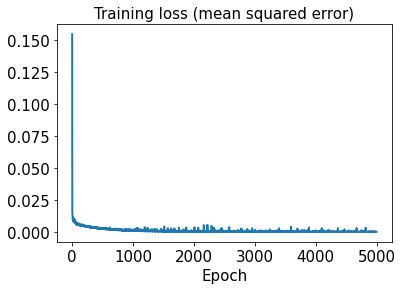

In [27]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

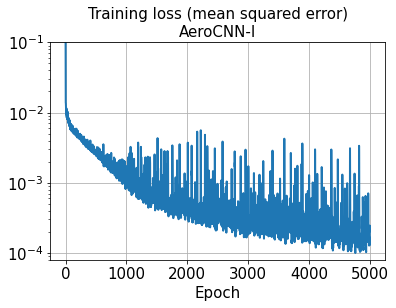

In [28]:
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-I', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.ylim([8e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

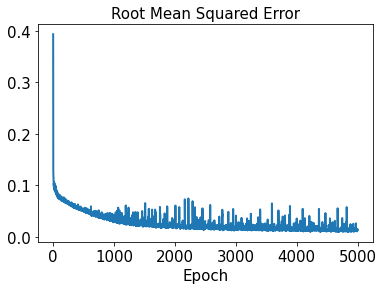

In [29]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [30]:
test_results = model.evaluate([x_train,aa_train])

47/47 [==============================] - 0s 4ms/step - loss: 3.0203e-06 - rmse: 0.0000e+00


In [31]:
decoded_train = model.predict([x_train,aa_train])

47/47 [==============================] - 0s 5ms/step


In [32]:
x_train.shape

(1488, 2, 50, 1)

In [33]:
decoded_test = model.predict([x_test, aa_test])

20/20 [==============================] - 0s 4ms/step


In [34]:
error_train_abs = np.abs(decoded_train - y_train)

In [35]:
error_test_abs = np.abs(decoded_test - y_test)

In [36]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [37]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [38]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [39]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [40]:
decoded_train.shape

(1488, 2, 1)

In [41]:
os.chdir("D:\\TrainedModels\\20220929")
model.save('AeroCNN-I_2FClayer.h5', overwrite=True, include_optimizer=True, save_format='h5')

In [42]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.024658025894074963


In [43]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.17809619946081695


In [44]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,0,:] - y_train[:,0,:])**2) / np.sum(y_train[:,0,:]**2))
print(l2_error_Cl_train)

0.02272889363588208


In [45]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,1,:] - y_train[:,1,:])**2) / np.sum(y_train[:,1,:]**2))
print(l2_error_Cd_train)

0.05558789844104786


In [46]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,0,:] - y_test[:,0,:])**2) / np.sum(y_test[:,0,:]**2))
print(l2_error_Cl_test)

0.1743669637554949


In [47]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,1,:] - y_test[:,1,:])**2) / np.sum(y_test[:,1,:]**2))
print(l2_error_Cd_test)

0.2528539076826231


In [48]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.029200441918592585, 0.017781307568485134, 0.0175383838061359, 0.10928166875481407, 0.09408915523009555, 0.03271202224794024, 0.010933307299408392, 0.01736814589027111, 0.011463513602477379, 0.009162712712309265, 0.0051718657600003685, 0.004531637689498426, 0.0032345683272577727, 0.002581490339358111, 0.010552314979828151, 0.005288459018925248, 0.017607523655193236, 0.028962040376056018, 0.03126116667149133, 0.026222962397719252, 0.05543191115006712, 0.07185141235695837, 0.03887380790368543, 0.007984377144975926, 0.007935746940702284, 0.006461800209467254, 0.009241498796719828, 0.008015402622078205, 0.0104104614026081, 0.02024580579960287, 0.022284196724180087, 0.010531263673388556, 0.038570127684924696, 0.004406183672803958, 0.015381944766581983, 0.032368355984296986, 0.060465777372324184, 0.16466180896389196, 0.03452179493360128, 0.013424158259289394, 0.025869744166253202, 0.024677667288676246, 0.025700641031660507, 0.022967339277337767, 0.04951577792198776, 0.0445544990339278, 0.0

In [49]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.060329285776688946, 0.006769619792280104, 0.04792147064586288, 0.032660115716615395, 0.06502613050115669, 0.03710774675185681, 0.016287385876007025, 0.01879841200722786, 0.007283129739271333, 0.0334716563698087, 0.2770863871545967, 0.23541559880140914, 0.1946192619247413, 0.576227947713497, 0.3421061596145128, 0.047621248764886055, 0.05642161319752266, 0.05985694843034169, 0.04653832412817871, 0.08825635574549241, 1.0155606279335314, 0.11819213414963477, 0.12394249690699573, 0.1616180074214342, 0.15108532389393786, 0.14234525384905397, 0.0947939754668191, 0.07854389342210534, 0.06077329676364821, 0.09376231053614174, 0.38451201293250903, 0.22511974308149593, 0.027023298770645014, 0.06238270380300257, 0.05007553780209532, 0.1765354496523002, 0.500507261885651, 1.015689338058046, 0.3121160099165495, 0.18625877860152795, 0.09722383589856547, 0.15552486136446442, 0.875646199994724, 0.031164465904484708, 0.19055945509099173, 0.2581807242819831, 0.021695448683793903, 0.04648821320767154, 

In [50]:
l2_error_Cl_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))
    l2_error_Cl_train_list.append(l2_error_Cl_train_data)
print(l2_error_Cl_train_list)

[0.028891385988807347, 0.015266701499109235, 0.00798140589002285, 0.10709276210461938, 0.08689365971927433, 0.030130689468575004, 0.010290540357084614, 0.017287055644724596, 0.011467793638015054, 0.00908443021911957, 0.004207793300638986, 0.004378209250621508, 0.0017777563344944668, 0.002443100582603983, 0.010170309389900769, 0.004847703179687557, 0.017584720115497703, 0.02846966514863486, 0.029661141716469767, 0.016532510035323154, 0.026616576970643936, 0.06955642973289874, 0.03874160930261013, 0.007838807441476747, 0.007929414830665586, 0.006400593231784603, 0.007511447433721599, 0.007877977551810397, 0.010030622210206097, 0.017658884753524538, 0.02092386350753421, 0.0032266328011005072, 0.036266518444769524, 0.002318142969203336, 0.011042890396918215, 0.019664187482847616, 0.038498180820690855, 0.15988689264754782, 0.032787026349698475, 0.009800250072803992, 0.024927032986597004, 0.009422574545897231, 0.022891085594786073, 0.02093299161274374, 0.0503049928684454, 0.04338939873533621

In [51]:
l2_error_Cd_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))
    l2_error_Cd_train_list.append(l2_error_Cd_train_data)
print(l2_error_Cd_train_list)

[0.09995598251034249, 0.19777874540025792, 0.23474274805449188, 0.1434824819849012, 0.3201329134423923, 0.2681138107181147, 0.11383896778405844, 0.06306625503464812, 0.0003697383933559591, 0.040400706841671144, 0.08201300262353795, 0.026689286061650365, 0.048847922376191476, 0.011829904922842093, 0.03515931922394937, 0.019456177780331277, 0.026782752295089245, 0.14109949634925056, 0.2426523641741876, 0.34106965752119933, 0.26111150276486206, 0.15314631196000805, 0.07263788350516, 0.042346474569348556, 0.012463336238318154, 0.025531733602055216, 0.12087154948977921, 0.027497915466869, 0.03840576149558151, 0.11410531903971655, 0.07116857582363596, 0.07071461694345255, 0.06730245415304953, 0.022291751073350168, 0.13428352368686625, 0.48540848686608873, 0.4478088727872916, 0.29015116759022924, 0.22870445490117786, 0.284006972894186, 0.20944543782666467, 0.36809936888274564, 0.11622384753281555, 0.04754729547799335, 0.0382449299927988, 0.05423185379237421, 0.008692463642662844, 0.0534270267

In [52]:
np.sqrt(np.sum((decoded_train[:,1,:][36] - y_train[:,1,:][36])**2) / np.sum(y_train[:,1,:][36]**2))

0.4478088727872916

In [53]:
l2_error_Cl_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cl_test_data = np.sqrt(np.sum((decoded_test[:,0,:][i] - y_test[:,0,:][i])**2) / np.sum(y_test[:,0,:][i]**2))
    l2_error_Cl_test_list.append(l2_error_Cl_test_data)
print(l2_error_Cl_test_list)

[0.06008495273090524, 0.0022373275318482754, 0.04414035082058168, 0.03127624633325761, 0.05643725845996149, 0.022717299174983163, 0.016164992246777105, 0.017703646072873617, 0.007113485183434769, 0.01667985259455486, 0.28076349596243894, 0.24060555893111482, 0.20173300933011573, 0.591563321104471, 0.35284079378148886, 0.04694200132315541, 0.05510843132972691, 0.05741079080714199, 0.04650131450170851, 0.08845309000495483, 1.4620364377062298, 0.11829920378001446, 0.1238904904846915, 0.1615772714334527, 0.15089354734963886, 0.14231257831538693, 0.09478965329121532, 0.07856638400352474, 0.05848748965075248, 0.08935029153679155, 0.3918744345522164, 0.23463061269645238, 0.02626840182753485, 0.06311695603276342, 0.04709680576896559, 0.1767254704583196, 0.502171317218659, 1.0329273355053008, 0.31057624361865915, 0.186063242834999, 0.09721483173668578, 0.1553222525360758, 0.8787747559835013, 0.02898174076198113, 0.19302400891705493, 0.2638008060621298, 0.008071494409078301, 0.0443516056165692, 

In [54]:
l2_error_Cd_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cd_test_data = np.sqrt(np.sum((decoded_test[:,1,:][i] - y_test[:,1,:][i])**2) / np.sum(y_test[:,1,:][i]**2))
    l2_error_Cd_test_list.append(l2_error_Cd_test_data)
print(l2_error_Cd_test_list)

[0.06482305563720599, 0.03858076259977854, 0.2533011098628562, 0.181353512913846, 0.32278644392816325, 0.15487075832793495, 0.04381874932362214, 0.18288177053666466, 0.038490580467977355, 0.4054768239990082, 0.11107466748185245, 0.1038799442731901, 0.04271909159867066, 0.3993417947005754, 0.23367428599626466, 0.051826839272462163, 0.3732771730248028, 0.5062472067493936, 0.06438144819710058, 0.032973386616786025, 0.06025127760269665, 0.0992777501383081, 0.15408543653559822, 0.20648345032251075, 0.3467693861944615, 0.1909312250159771, 0.10077935075884155, 0.05518535144793076, 0.31861068541547166, 0.3003872075285628, 0.1101846322910092, 0.16336062651668776, 0.038185686531226094, 0.013325014672122918, 0.26487142099006084, 0.01871663829521558, 0.2421230946084247, 0.4144495485789404, 0.6980579669874348, 0.32272420400600005, 0.10683692959221892, 0.22760548168521713, 0.5908555322348055, 0.05928904220464927, 0.15193039940264713, 0.18141171473574977, 0.06355136745356539, 0.05949214505542522, 0.4

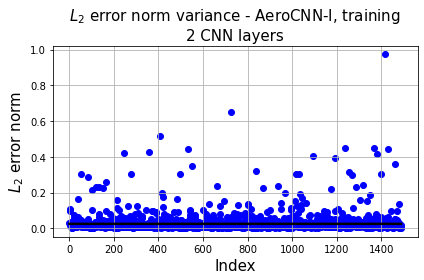

In [55]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, training\n2 CNN layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

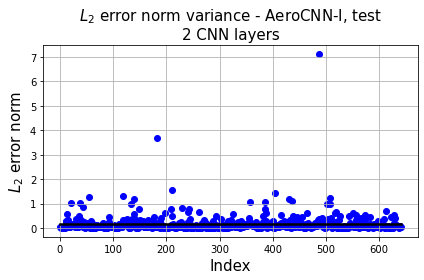

In [56]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, test\n2 CNN layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

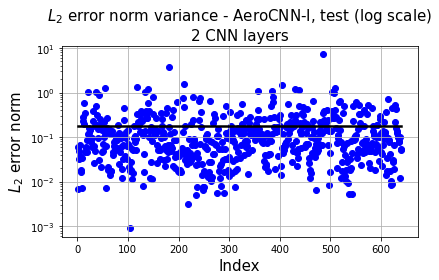

In [57]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, test (log scale)\n2 CNN layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

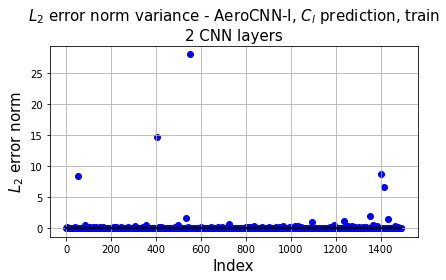

In [58]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, train\n2 CNN layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

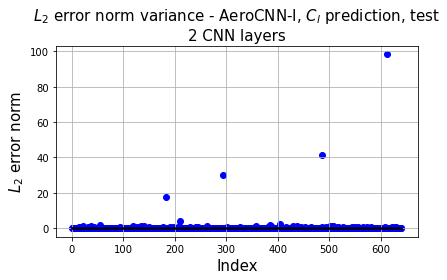

In [59]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, test\n2 CNN layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

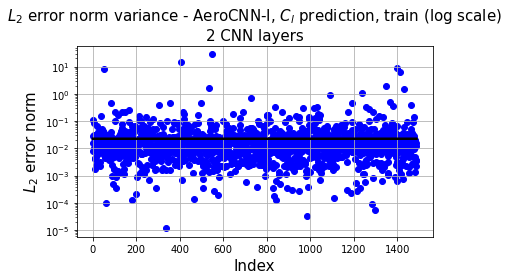

In [60]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, train (log scale)\n2 CNN layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

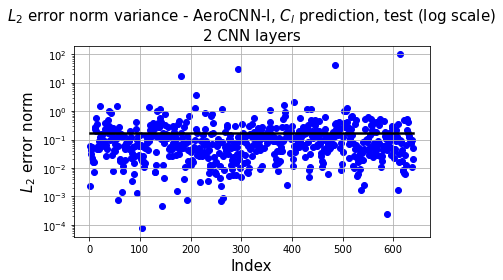

In [61]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, test (log scale)\n2 CNN layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

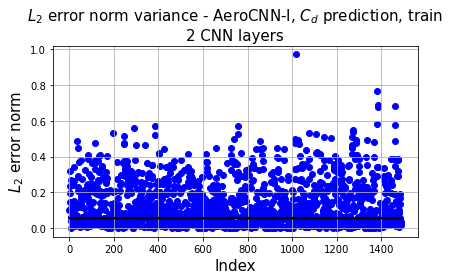

In [62]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cd_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cd_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_d$ prediction, train\n2 CNN layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

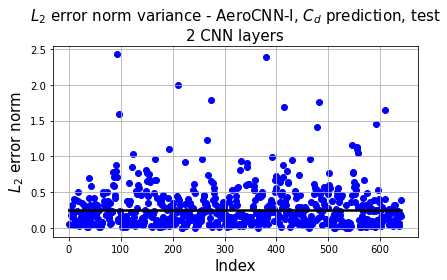

In [63]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cd_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cd_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_d$ prediction, test\n2 CNN layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

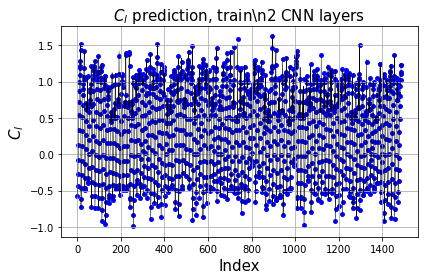

In [64]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, train\n2 CNN layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

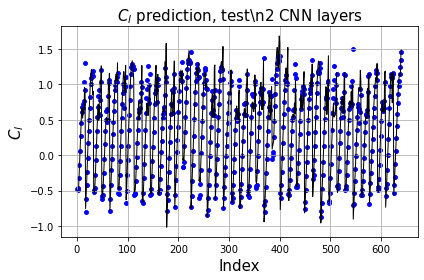

In [65]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,0,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, test\n2 CNN layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

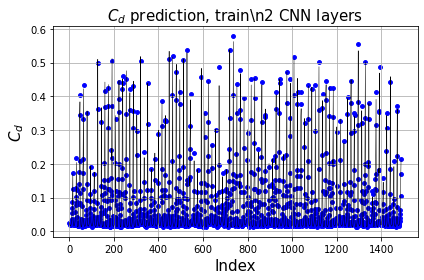

In [66]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, train\n2 CNN layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

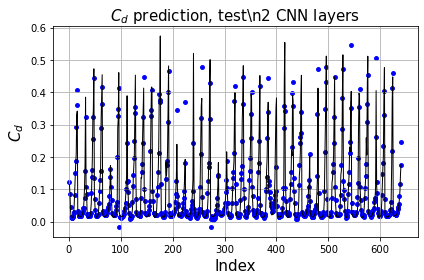

In [67]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,1,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, test\n2 CNN layers', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

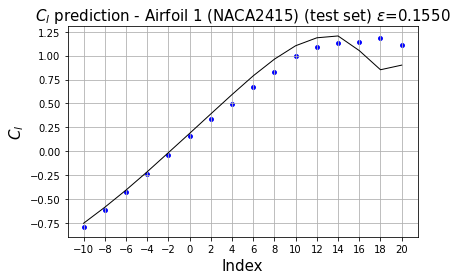

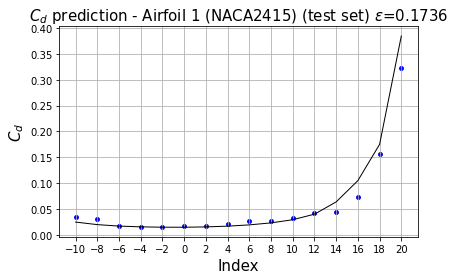

In [68]:
airfoiltest1_predict = decoded_test[16*1:16*2]

airfoiltest1_cl=y_test[16*1:16*2,0,:]
airfoiltest1_cd=y_test[16*1:16*2,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [69]:
decoded_test.shape

(640, 2, 1)

In [70]:
np.unique(geo_test)

array([b'NACA000834', b'NACA0010', b'NACA001034', b'NACA001264',
       b'NACA0024', b'NACA1408', b'NACA2408', b'NACA2411', b'NACA2415',
       b'NACA2418', b'NACA4412', b'NACA4415', b'NACA4421', b'NACA63010a',
       b'NACA63012a', b'NACA631412', b'NACA63210', b'NACA632415',
       b'NACA632615', b'NACA634221', b'NACA64008a', b'NACA64108',
       b'NACA64110', b'NACA6412', b'NACA64206', b'NACA64209',
       b'NACA64a210', b'NACA651412', b'NACA661212', b'NACA663218',
       b'RAE100', b'RAE101', b'RAE102', b'RAE2822', b'RAE5212',
       b'RAE5214', b'RAE69CK', b'RAF19', b'RAF31', b'RAF48'], dtype='|S32')

In [71]:
geo_test.shape[0]/16

40.0

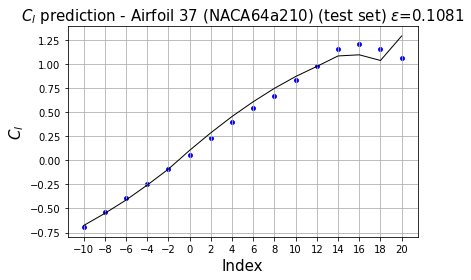

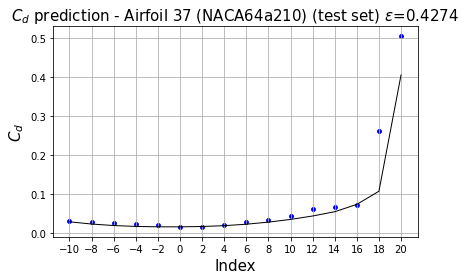

In [72]:
airfoiltest37_predict = decoded_test[16*36:16*37]

airfoiltest37_cl=y_test[16*36:16*37,0,:]
airfoiltest37_cd=y_test[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest37_predict[:,0,:] - airfoiltest37_cl)**2) / np.sum(airfoiltest37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest37_predict[:,1,:] - airfoiltest37_cd)**2) / np.sum(airfoiltest37_cd**2))

plt.plot(alpha, airfoiltest37_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest37_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 37 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[37*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest37_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest37_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 37 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[37*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

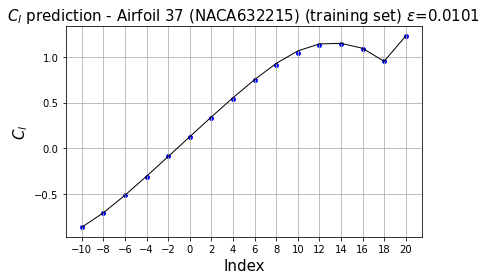

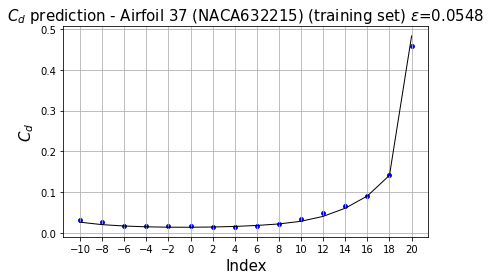

In [73]:
airfoiltrain37_predict = decoded_train[16*36:16*37]

airfoiltrain37_cl=y_train[16*36:16*37,0,:]
airfoiltrain37_cd=y_train[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain37_predict[:,0,:] - airfoiltrain37_cl)**2) / np.sum(airfoiltrain37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain37_predict[:,1,:] - airfoiltrain37_cd)**2) / np.sum(airfoiltrain37_cd**2))

plt.plot(alpha, airfoiltrain37_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltrain37_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain37_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltrain37_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [74]:
np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))

0.17809619946081695

In [75]:
decoded_train.shape

(1488, 2, 1)

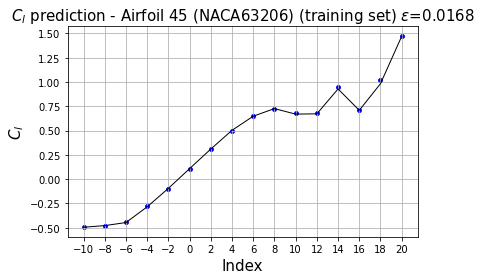

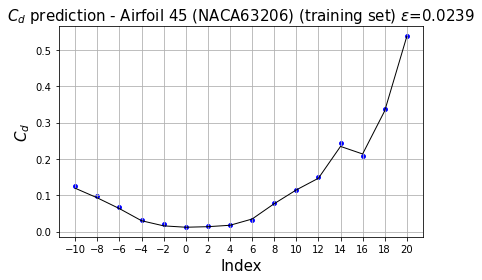

In [76]:
airfoiltrain45_predict = decoded_train[16*44:16*45]

airfoiltrain45_cl=y_train[16*44:16*45,0,:]
airfoiltrain45_cd=y_train[16*44:16*45,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain45_predict[:,0,:] - airfoiltrain45_cl)**2) / np.sum(airfoiltrain45_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain45_predict[:,1,:] - airfoiltrain45_cd)**2) / np.sum(airfoiltrain45_cd**2))

plt.plot(alpha, airfoiltrain45_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltrain45_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCl),
          fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain45_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltrain45_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCd),
          fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

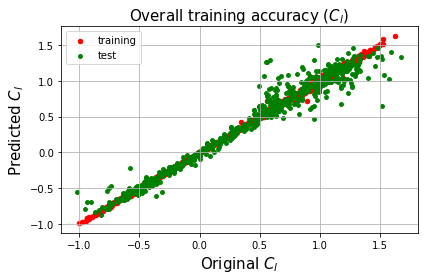

In [77]:
plt.scatter(y_train[:,0,:], decoded_train[:,0,:], c='r', s=20)
plt.scatter(y_test[:,0,:], decoded_test[:,0,:], c='g', s=15)
plt.xlabel('Original $C_l$', fontsize=15)
plt.ylabel('Predicted $C_l$', fontsize=15)
plt.title('Overall training accuracy ($C_l$)', fontsize=15)

plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

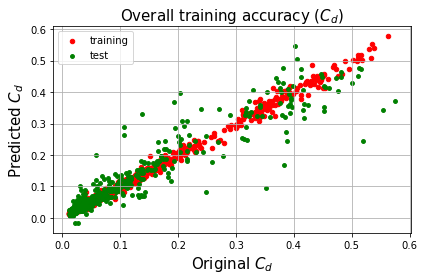

In [78]:
plt.scatter(y_train[:,1,:], decoded_train[:,1,:], c='r', s=20)
plt.scatter(y_test[:,1,:], decoded_test[:,1,:], c='g', s=15)
plt.xlabel('Original $C_d$', fontsize=15)
plt.ylabel('Predicted $C_d$', fontsize=15)
plt.title('Overall training accuracy ($C_d$)', fontsize=15)
plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

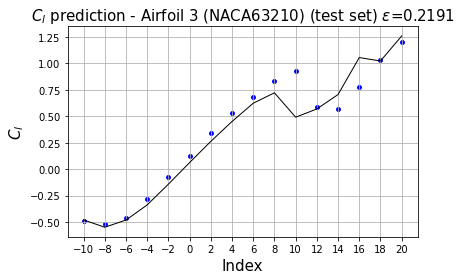

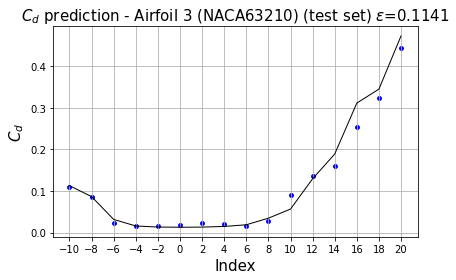

In [79]:
airfoiltest1_predict = decoded_test[16*2:16*3]

airfoiltest1_cl=y_test[16*2:16*3,0,:]
airfoiltest1_cd=y_test[16*2:16*3,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

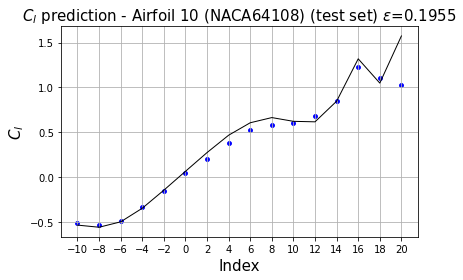

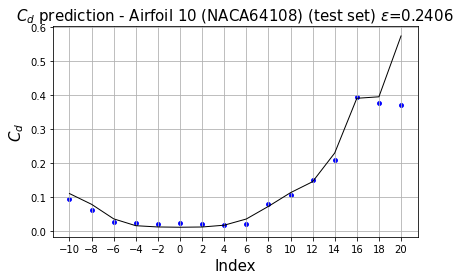

In [80]:
airfoiltest1_predict = decoded_test[16*10:16*11]

airfoiltest1_cl=y_test[16*10:16*11,0,:]
airfoiltest1_cd=y_test[16*10:16*11,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 10 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[10*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 10 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[10*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()